# Change signal

Assessment of model change signal over the future period relative to the historical.


In [1]:
import warnings
warnings.filterwarnings('ignore')

import sys
import numpy as np
import matplotlib.pyplot as plt
import cmocean
import cartopy.crs as ccrs

sys.path.append('/g/data/xv83/users/at2708/bias_adjustment/evaluation/npcp/results')
import utils

In [2]:
def calc_change_signal(da_future, da, var):
    """Calculate the difference in the change signal between GCM and RCM """
    
    if var == 'pr':
        change_signal = (da_future.mean(dim='time') - da.mean(dim='time'))/abs(da.mean(dim='time'))*100
    else:
        change_signal = da_future.mean(dim='time') - da.mean(dim='time')
    
    return change_signal

In [3]:
def get_data(var, gcm, rcm, task):
    """Get data needed for the evaluation"""

    assert gcm in ['CSIRO-ACCESS-ESM1-5']
    assert rcm in ['BOM-BARPA-R', 'CSIRO-CCAM-2203', 'UQ-DES-CCAM-2105']
    assert task in ['historical', 'xvalidation']

    start_date = '1990-01-01' if task == 'xvalidation' else '1980-01-01' 
    end_date = '2019-12-31'

    start_date_future = '2060-01-01'
    end_date_future = '2099-12-31'

    da_dict = {}

    da_dict['gcm'] = utils.get_npcp_data(
        var,
        gcm,
        'GCM',
        'raw',
        'task-reference',
        start_date,
        end_date,
        'AU'
    )

    da_dict['gcm_future'] = utils.get_npcp_data(
        var,
        gcm,
        'GCM',
        'raw',
        'task-reference',
        start_date_future,
        end_date_future,
        'AU'
    )
    
    da_dict['rcm_raw'] = utils.get_npcp_data(
        var,
        gcm,
        rcm,
        'raw',
        'task-reference',
        start_date,
        end_date,
        'AU'
    )
    
    da_dict['rcm_raw_future'] = utils.get_npcp_data(
        var,
        gcm,
        rcm,
        'raw',
        'task-reference',
        start_date_future,
        end_date_future,
        'AU'
    )
    
    da_dict['rcm_ecdfm'] = utils.get_npcp_data(
        var,
        gcm,
        rcm,
        'ecdfm',
        f'task-{task}',
        start_date,
        end_date,
        'AU'
    )

    da_dict['rcm_ecdfm_future'] = utils.get_npcp_data(
        var,
        gcm,
        rcm,
        'ecdfm',
        'task-projection',
        start_date_future,
        end_date_future,
        'AU'
    )

    da_dict['rcm_qme'] = utils.get_npcp_data(
        var,
        gcm,
        rcm,
        'qme',
        f'task-{task}',
        start_date,
        end_date,
        'AU'
    )

    da_dict['rcm_qme_future'] = utils.get_npcp_data(
        var,
        gcm,
        rcm,
        'qme',
        'task-projection',
        start_date_future,
        end_date_future,
        'AU'
    )
    if task == 'xvalidation':
        da_dict['rcm_qdm'] = utils.get_npcp_data(
            var,
            gcm,
            rcm,
            'qdm',
            f'task-{task}',
            start_date,
            end_date,
            'AU'
        )

        da_dict['rcm_qdm_future'] = utils.get_npcp_data(
            var,
            gcm,
            rcm,
            'qdm',
            'task-projection',
            start_date_future,
            end_date_future,
            'AU'
        )
        
    # TODO: Add additional bias correction methods as data becomes available 

    return da_dict


In [4]:
def plot_mean_bias(ax, da_model_future, da_model, var, cmap, levels, model_name,  ob_fractions=None):
    """Plot the mean bias for a particular model"""
    
    change_signal = calc_change_signal(da_model_future, da_model, var) 

    change_signal = utils.clip_data(change_signal, utils.get_aus_shape())
    if ob_fractions is not None:
        change_signal = utils.mask_by_pr_ob_fraction(change_signal, ob_fractions, threshold=0.9)  

    spatial_ave = np.nanmean(change_signal) 
    
    units = '%' if var == 'pr' else da_model.attrs['units']
    
    im = change_signal.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        levels=levels,
        extend='both', 
        add_colorbar=False
    ) #cbar_kwargs={'label': units},
    ax.set_title(model_name)
    ax.coastlines()
    cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.04)
    cbar.ax.tick_params(labelsize=14)  
    cbar.set_label(units, fontsize=14) 
    ax.text(0.02, 0.02, f'Spatial average: {spatial_ave:.2f} {units}', transform=ax.transAxes)



In [5]:
def plot_comparison(var, gcm, rcm, task, cmap, levels):
    """Plot the complete comparison"""

    da_dict = get_data(var, gcm, rcm, task)
    if var == 'pr':
        ob_fractions = utils.get_pr_weights(gcm, task)
    else:
        ob_fractions = None
 
      
    ncols = 5 if task == 'xvalidation' else 4
    fig = plt.figure(figsize=[7 * ncols, 5])
    ax1 = fig.add_subplot(1, ncols, 1, projection=ccrs.PlateCarree())
    plot_mean_bias(
        ax1, da_dict['gcm_future'], da_dict['gcm'], var, cmap, levels, gcm, ob_fractions=ob_fractions)
    ax1.set_title(f'{gcm}', fontsize=16)
    
    ax2 = fig.add_subplot(1, ncols, 2, projection=ccrs.PlateCarree())
    plot_mean_bias(
        ax2, da_dict['rcm_raw_future'], da_dict['rcm_raw'], var, cmap, levels, f'{rcm} (raw)',ob_fractions=ob_fractions)
    ax2.set_title(f'{rcm} (raw)', fontsize=16)
    
    ax3 = fig.add_subplot(1, ncols, 3, projection=ccrs.PlateCarree())
    plot_mean_bias(
        ax3, da_dict['rcm_ecdfm_future'], da_dict['rcm_ecdfm'], var, cmap, levels, f'{rcm} (ecdfm)',ob_fractions=ob_fractions)
    ax3.set_title(f'{rcm} (ecdfm)', fontsize=16)

    ax4 = fig.add_subplot(1, ncols, 4, projection=ccrs.PlateCarree())
    plot_mean_bias(
        ax4, da_dict['rcm_qme_future'], da_dict['rcm_qme'], var, cmap, levels, f'{rcm} (qme)',ob_fractions=ob_fractions)
    ax4.set_title(f'{rcm} (qme)', fontsize=16)

    if task == 'xvalidation':
        ax5 = fig.add_subplot(1, ncols, 5, projection=ccrs.PlateCarree())
        plot_mean_bias(
            ax5, da_dict['rcm_qdm_future'], da_dict['rcm_qdm'], var, cmap, levels, f'{rcm} (qdm)', ob_fractions=ob_fractions)
        ax5.set_title(f'{rcm} (qdm)', fontsize=16)


    start_year = '1990' if task == 'xvalidation' else '1980' 
    end_year = '2019'
    start_year_future = '2060'
    end_year_future = '2099'
    
    long_name = da_dict['rcm_raw'].attrs['long_name']
    plt.suptitle(f'Change signal (model future {start_year_future}-{end_year_future} base period mean relative to model historical {start_year}-{end_year} base period mean) {long_name}', fontsize=16)
    plt.show()

# task-historical
Bias corrected data for the 1980-2019 period, using 1980-2019 as a training period.

In [6]:
variable = 'pr'
levels = np.arange(-56, 56.1, 10)
cmap = 'BrBG'

### ACCESS-ESM1-5

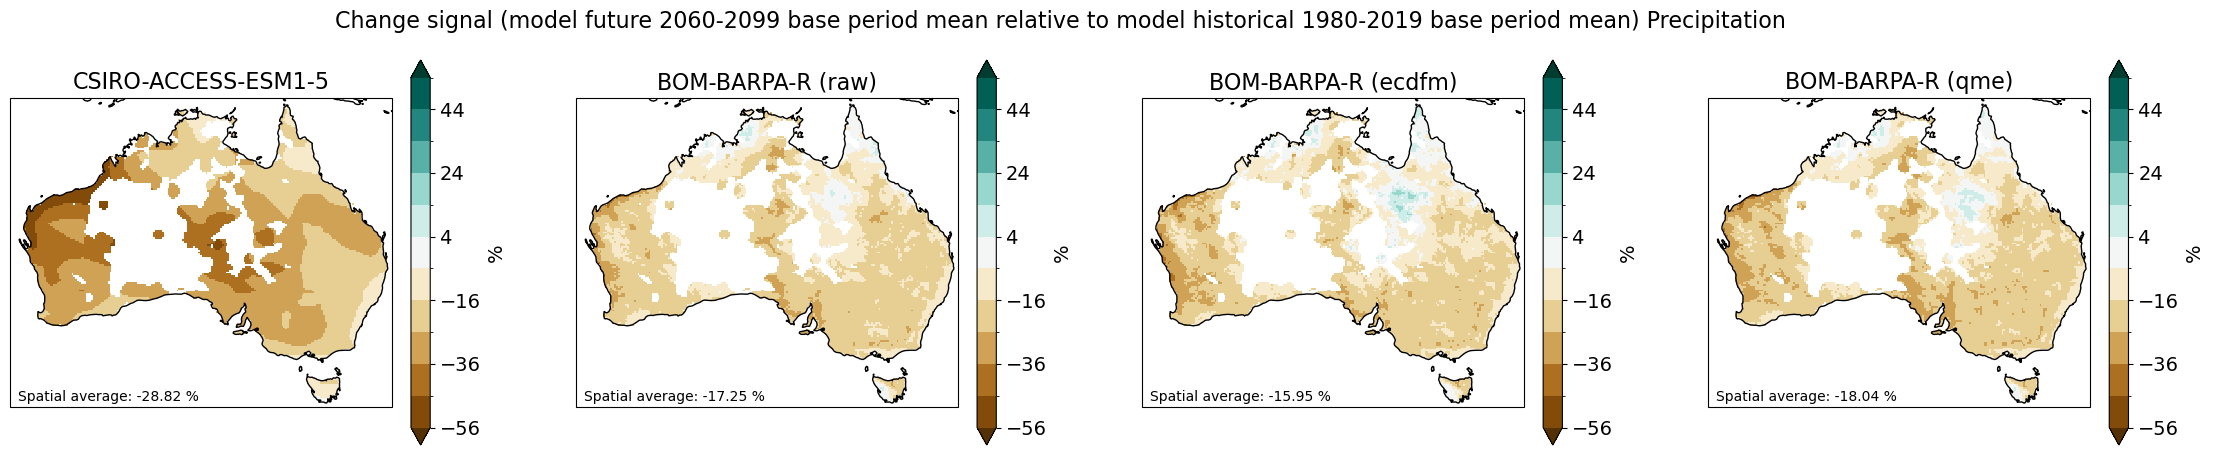

In [18]:
plot_comparison(variable, 'CSIRO-ACCESS-ESM1-5', 'BOM-BARPA-R', 'historical', cmap, levels)

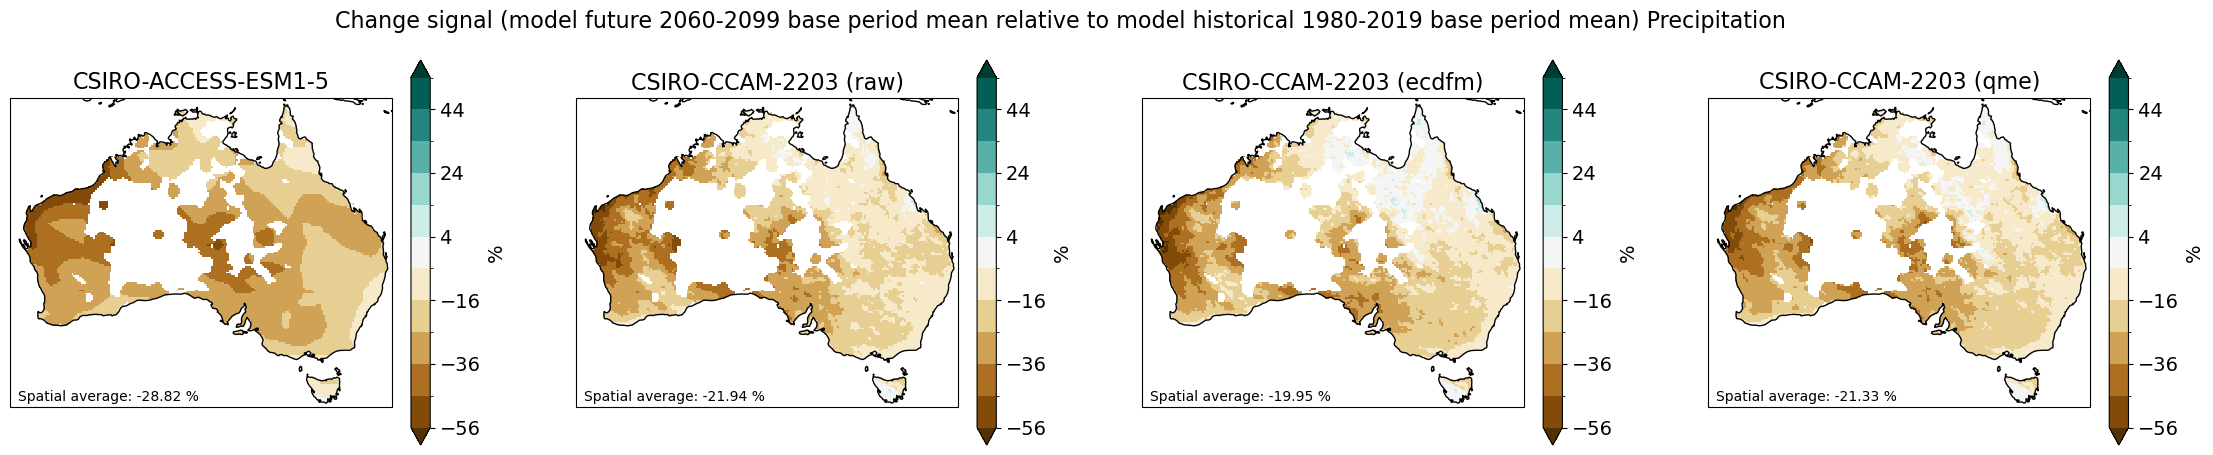

In [19]:
plot_comparison(variable, 'CSIRO-ACCESS-ESM1-5', 'CSIRO-CCAM-2203', 'historical', cmap, levels)

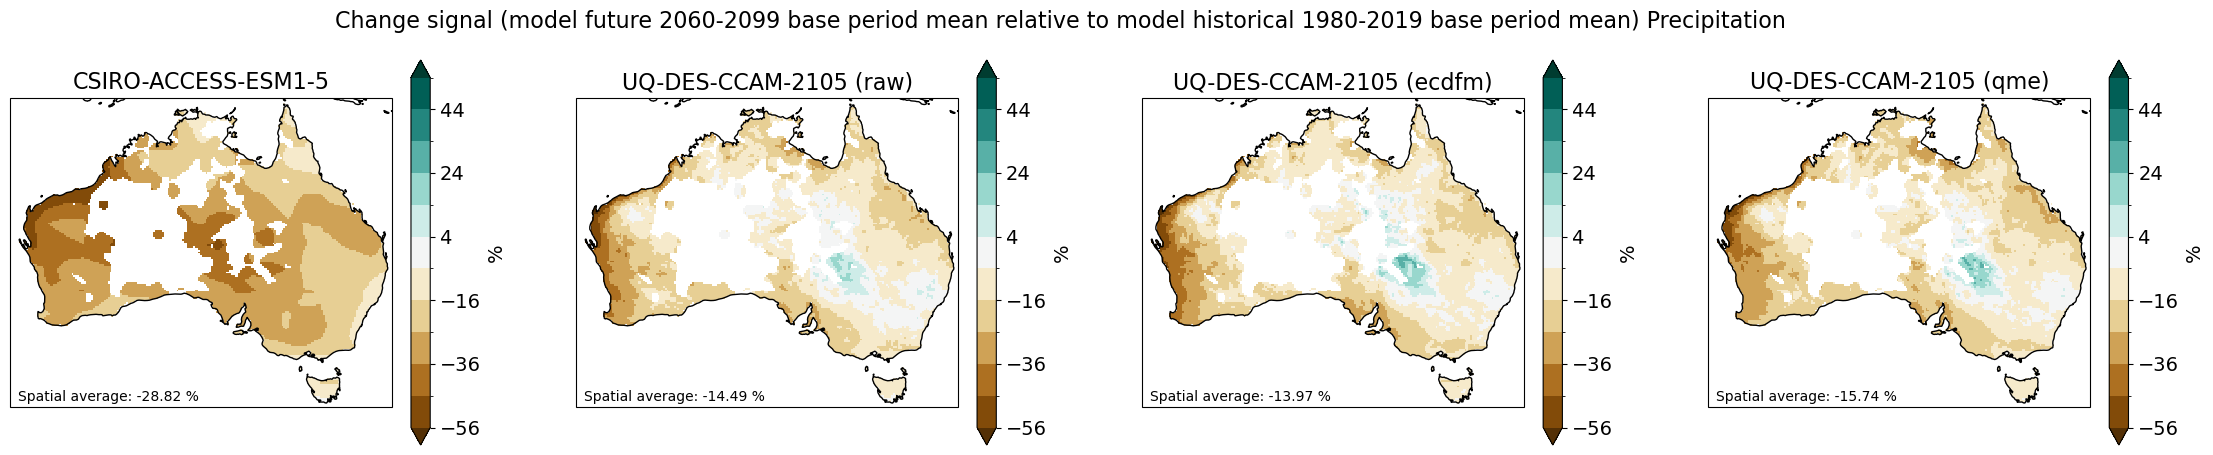

In [7]:
plot_comparison(variable, 'CSIRO-ACCESS-ESM1-5', 'UQ-DES-CCAM-2105', 'historical', cmap, levels)

# task-xvalidation

### ACCESS-ESM1-5
Bias corrected data for the 1990-2019 period, using 1960-1989 as a training period.

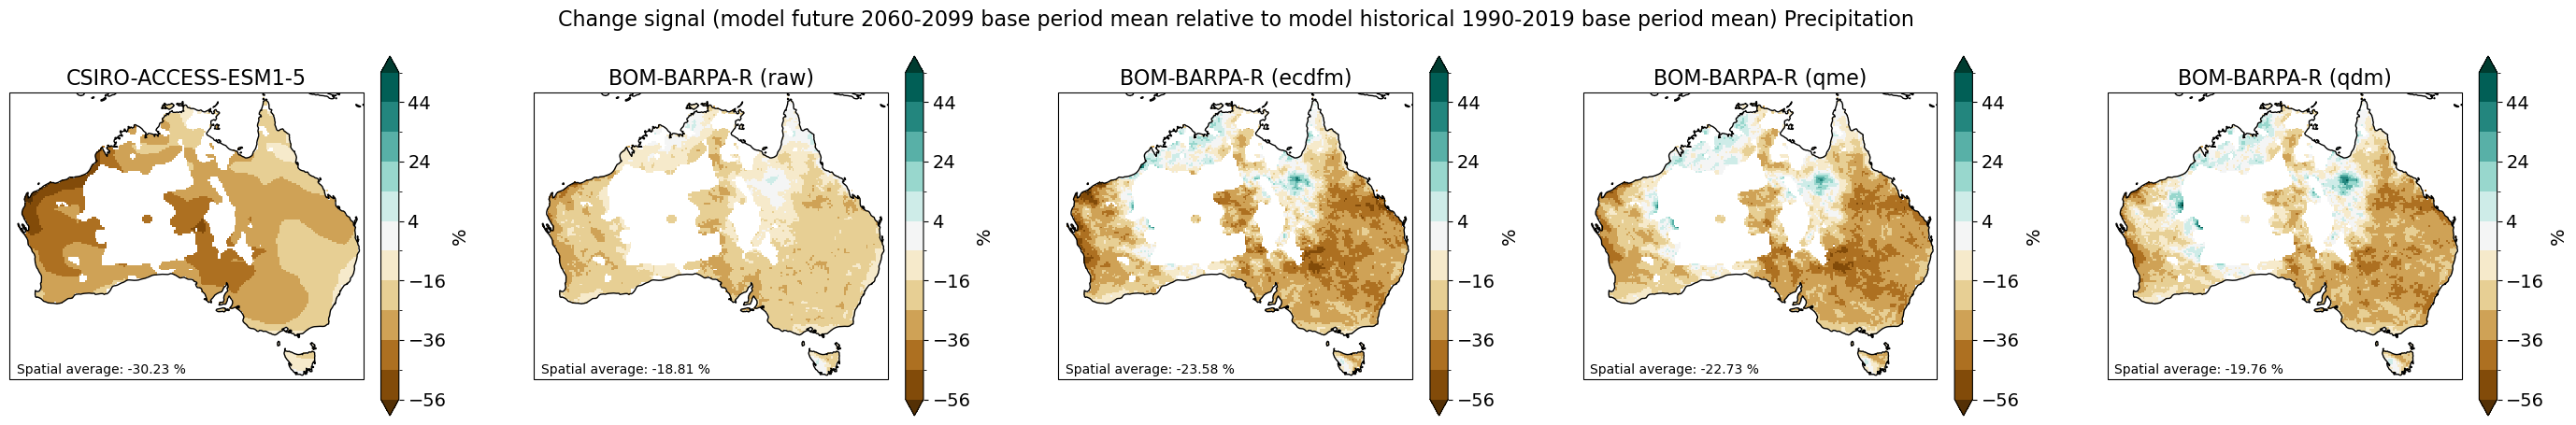

In [8]:
plot_comparison(variable, 'CSIRO-ACCESS-ESM1-5', 'BOM-BARPA-R', 'xvalidation', cmap, levels)

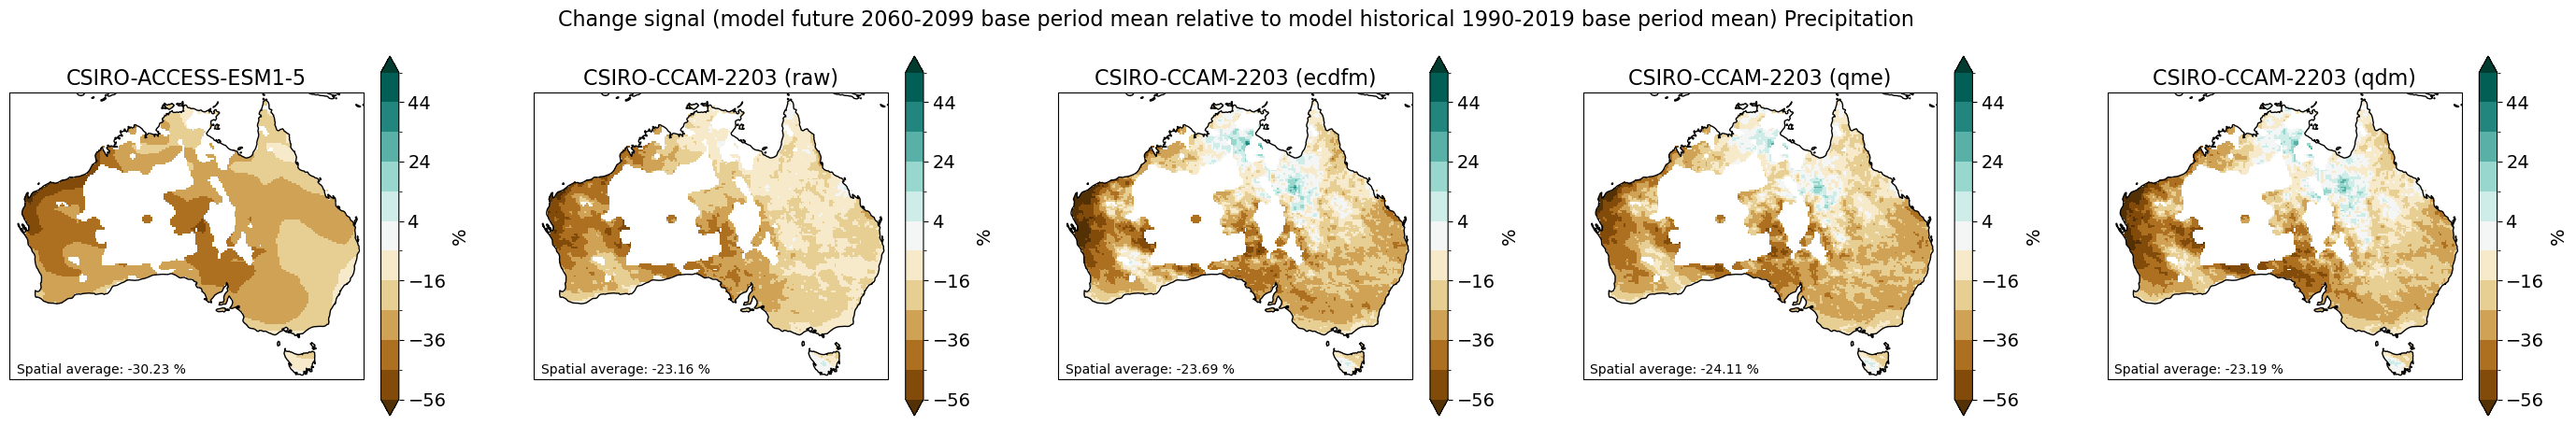

In [9]:
plot_comparison(variable, 'CSIRO-ACCESS-ESM1-5', 'CSIRO-CCAM-2203', 'xvalidation', cmap, levels)

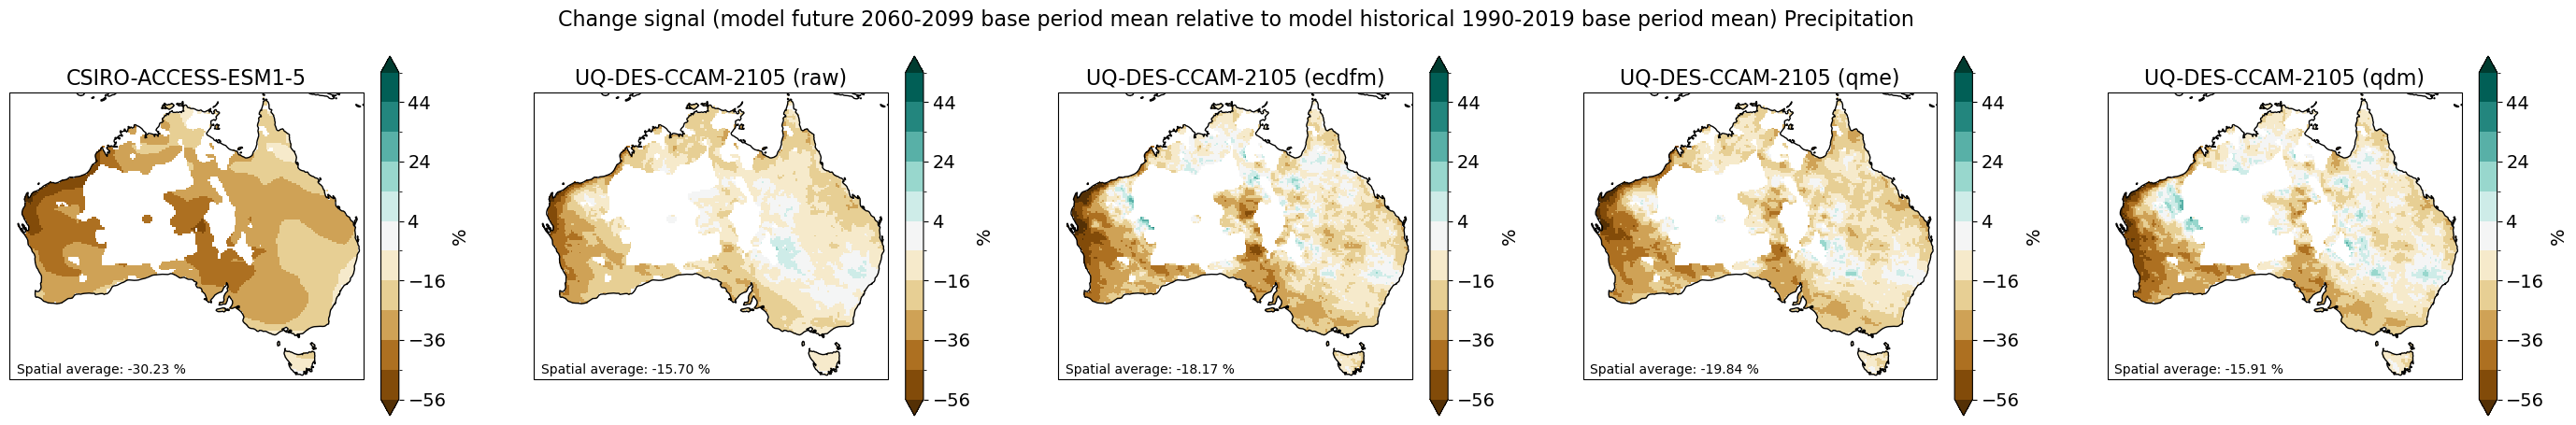

In [10]:
plot_comparison(variable, 'CSIRO-ACCESS-ESM1-5', 'UQ-DES-CCAM-2105', 'xvalidation', cmap, levels)

### Change signal bias-corrected RCM minus change signal raw RCM

In [3]:
def get_data(var, gcm, rcm, task):
    """Get data needed for the evaluation"""

    assert gcm in ['CSIRO-ACCESS-ESM1-5']
    assert rcm in ['BOM-BARPA-R', 'CSIRO-CCAM-2203', 'UQ-DES-CCAM-2105']
    assert task in ['historical', 'xvalidation']

    start_date = '1990-01-01' if task == 'xvalidation' else '1980-01-01' 
    end_date = '2019-12-31'

    start_date_future = '2060-01-01'
    end_date_future = '2099-12-31'

    da_dict = {}

    da_dict['gcm'] = utils.get_npcp_data(
        var,
        gcm,
        'GCM',
        'raw',
        'task-reference',
        start_date,
        end_date,
        'AU'
    )

    da_dict['gcm_future'] = utils.get_npcp_data(
        var,
        gcm,
        'GCM',
        'raw',
        'task-reference',
        start_date_future,
        end_date_future,
        'AU'
    )
    
    da_dict['rcm_raw'] = utils.get_npcp_data(
        var,
        gcm,
        rcm,
        'raw',
        'task-reference',
        start_date,
        end_date,
        'AU'
    )
    
    da_dict['rcm_raw_future'] = utils.get_npcp_data(
        var,
        gcm,
        rcm,
        'raw',
        'task-reference',
        start_date_future,
        end_date_future,
        'AU'
    )
    
    da_dict['rcm_ecdfm'] = utils.get_npcp_data(
        var,
        gcm,
        rcm,
        'ecdfm',
        f'task-{task}',
        start_date,
        end_date,
        'AU'
    )

    da_dict['rcm_ecdfm_future'] = utils.get_npcp_data(
        var,
        gcm,
        rcm,
        'ecdfm',
        'task-projection',
        start_date_future,
        end_date_future,
        'AU'
    )

    da_dict['rcm_qme'] = utils.get_npcp_data(
        var,
        gcm,
        rcm,
        'qme',
        f'task-{task}',
        start_date,
        end_date,
        'AU'
    )

    da_dict['rcm_qme_future'] = utils.get_npcp_data(
        var,
        gcm,
        rcm,
        'qme',
        'task-projection',
        start_date_future,
        end_date_future,
        'AU'
    )
    if task == 'xvalidation':
        da_dict['rcm_qdm'] = utils.get_npcp_data(
            var,
            gcm,
            rcm,
            'qdm',
            f'task-{task}',
            start_date,
            end_date,
            'AU'
        )

        da_dict['rcm_qdm_future'] = utils.get_npcp_data(
            var,
            gcm,
            rcm,
            'qdm',
            'task-projection',
            start_date_future,
            end_date_future,
            'AU'
        )
        
    # TODO: Add additional bias correction methods as data becomes available 

    change_signal_model_raw = calc_change_signal(da_dict['rcm_raw_future'], da_dict['rcm_raw'], var)  
    

    return  da_dict, change_signal_model_raw


In [14]:
def plot_mean_bias(ax, change_signal_model_raw, da_model_future, da_model, var, cmap, levels, model_name,  ob_fractions=None):
    """Plot the mean bias for a particular model"""
    change_signal_model = calc_change_signal(da_model_future, da_model, var) 
    change_signal_diff = change_signal_model - change_signal_model_raw

    change_signal_diff = utils.clip_data(change_signal_diff, utils.get_aus_shape())
    if ob_fractions is not None:
        change_signal_diff = utils.mask_by_pr_ob_fraction(change_signal_diff, ob_fractions, threshold=0.9)  
    mae = np.nanmean(np.abs(change_signal_diff)) 
    
    units = '%' if var == 'pr' else da_model.attrs['units']
    
    im = change_signal_diff.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        levels=levels,
        extend='both', 
        add_colorbar=False
    ) #cbar_kwargs={'label': units},
    ax.set_title(model_name)
    ax.coastlines()
    cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.04)
    cbar.ax.tick_params(labelsize=10)  
    cbar.set_label(units, fontsize=10) 
    ax.text(0.02, 0.02, f'MAE: {mae:.2f} {units}', transform=ax.transAxes)


In [15]:
def plot_comparison(var, gcm, rcm, task, cmap, levels):
    """Plot the complete comparison"""

    da_dict, change_signal_model_raw = get_data(var, gcm, rcm, task)
    if var == 'pr':
        ob_fractions = utils.get_pr_weights(gcm, task)
    else:
        ob_fractions = None
 
      
    ncols = 5 if task == 'xvalidation' else 4
    fig = plt.figure(figsize=[7 * ncols, 5])
    ax1 = fig.add_subplot(1, ncols, 1, projection=ccrs.PlateCarree())
    plot_mean_bias(
        ax1, change_signal_model_raw, da_dict['rcm_ecdfm_future'], da_dict['rcm_ecdfm'], var, cmap, levels, f'{rcm} - {rcm} (ecdfm)',  ob_fractions=ob_fractions)   
    ax1.set_title(f'{rcm} (ecdfm)', fontsize=16)

    ax2 = fig.add_subplot(1, ncols, 2, projection=ccrs.PlateCarree())
    plot_mean_bias(
        ax2, change_signal_model_raw, da_dict['rcm_qme_future'], da_dict['rcm_qme'], var, cmap, levels, f'{rcm} - {rcm} (qme)',  ob_fractions=ob_fractions)   
    ax2.set_title(f'{rcm} (qme)', fontsize=16)

    if task == 'xvalidation':
        ax3 = fig.add_subplot(1, ncols, 3, projection=ccrs.PlateCarree())
        plot_mean_bias(
            ax3, change_signal_model_raw, da_dict['rcm_qdm_future'], da_dict['rcm_qdm'], var, cmap, levels, f'{rcm} - {rcm} (qdm)', ob_fractions=ob_fractions)
        ax3.set_title(f'{rcm} (qdm)', fontsize=16)


    start_year = '1990' if task == 'xvalidation' else '1980' 
    end_year = '2019'
    start_year_future = '2060'
    end_year_future = '2099'
    
    long_name = da_dict['rcm_raw'].attrs['long_name']
    plt.suptitle(f'Change signal difference (bias-corrected RCM change signal minus the raw RCM change signal ) {long_name}', fontsize=12)
    plt.show()

# task-historical
Bias corrected data for the 1980-2019 period, using 1980-2019 as a training period.

In [16]:
variable = 'pr'
levels = np.arange(-18, 18.1, 5)
cmap = 'BrBG'

### ACCESS-ESM1-5

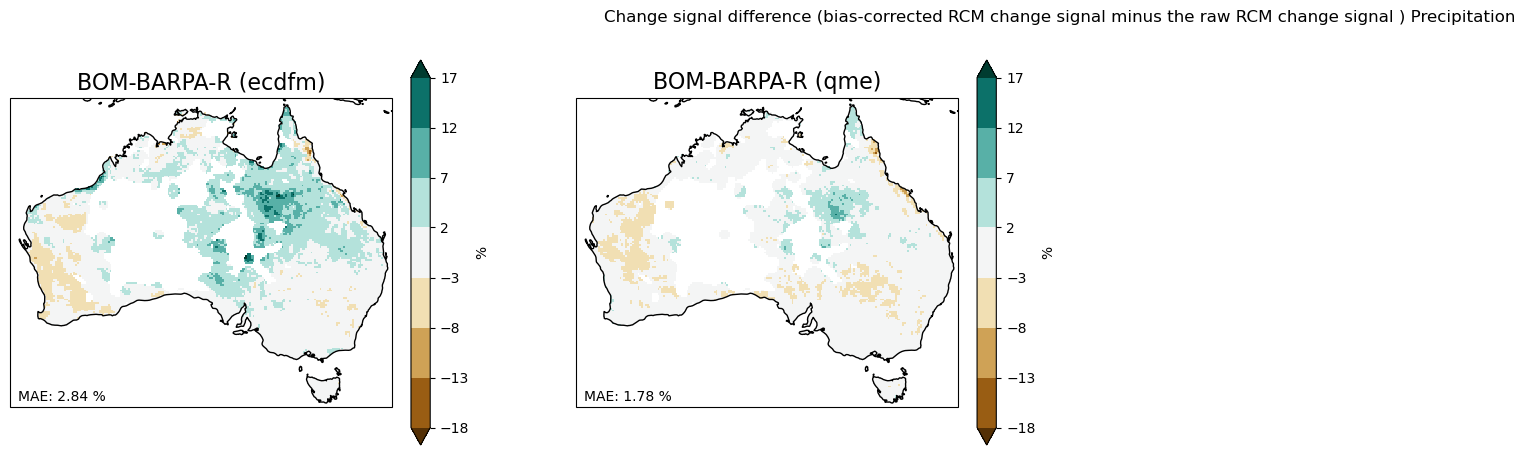

In [17]:
plot_comparison(variable, 'CSIRO-ACCESS-ESM1-5', 'BOM-BARPA-R', 'historical', cmap, levels)

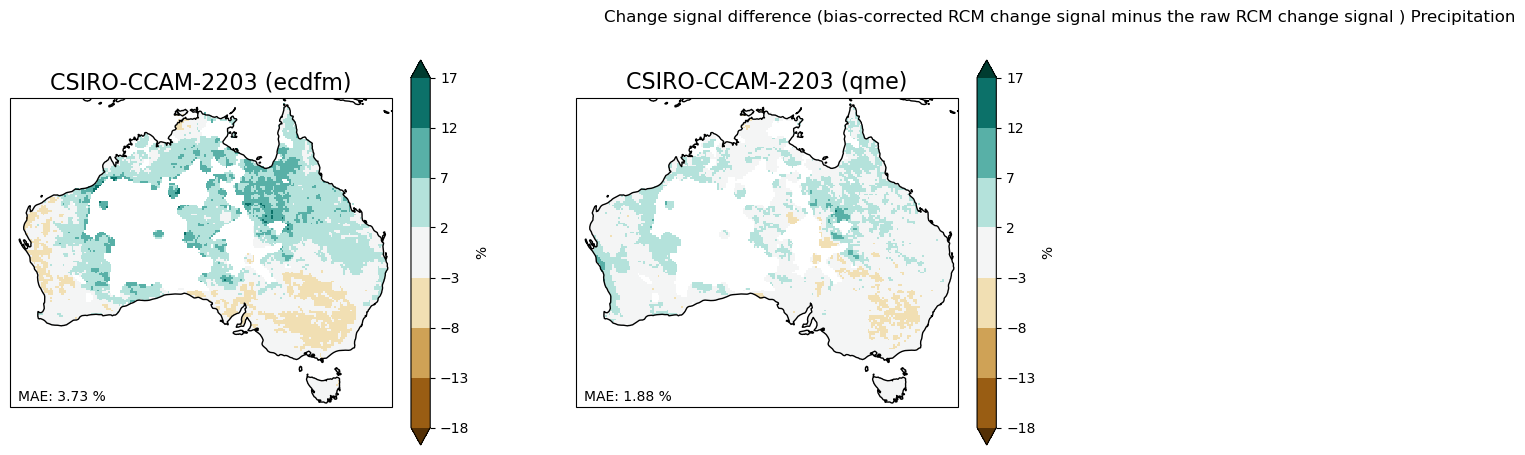

In [18]:
plot_comparison(variable, 'CSIRO-ACCESS-ESM1-5', 'CSIRO-CCAM-2203', 'historical', cmap, levels)

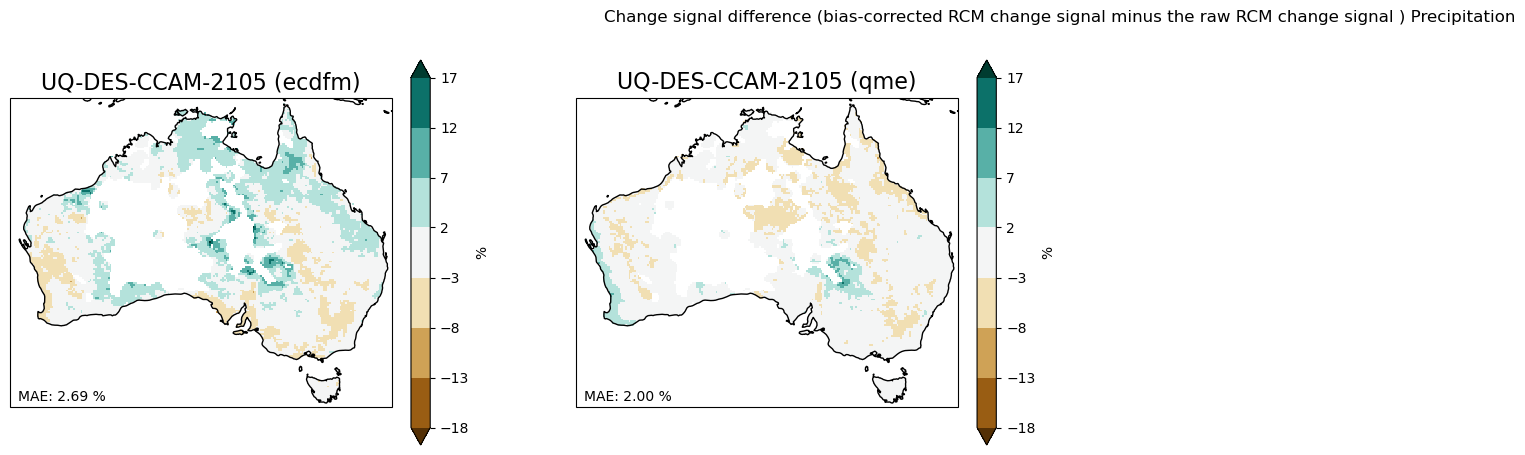

In [19]:
plot_comparison(variable, 'CSIRO-ACCESS-ESM1-5', 'UQ-DES-CCAM-2105', 'historical', cmap, levels)

# task-xvalidation

### ACCESS-ESM1-5
Bias corrected data for the 1990-2019 period, using 1960-1989 as a training period.

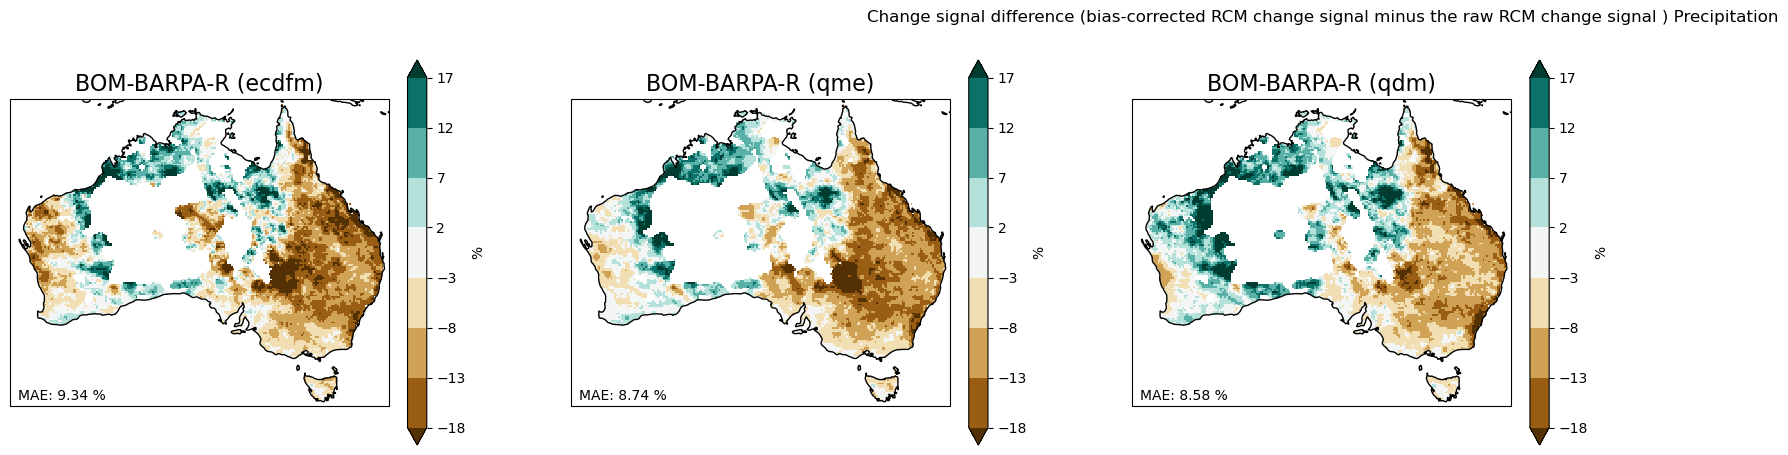

In [20]:
plot_comparison(variable, 'CSIRO-ACCESS-ESM1-5', 'BOM-BARPA-R', 'xvalidation', cmap, levels)

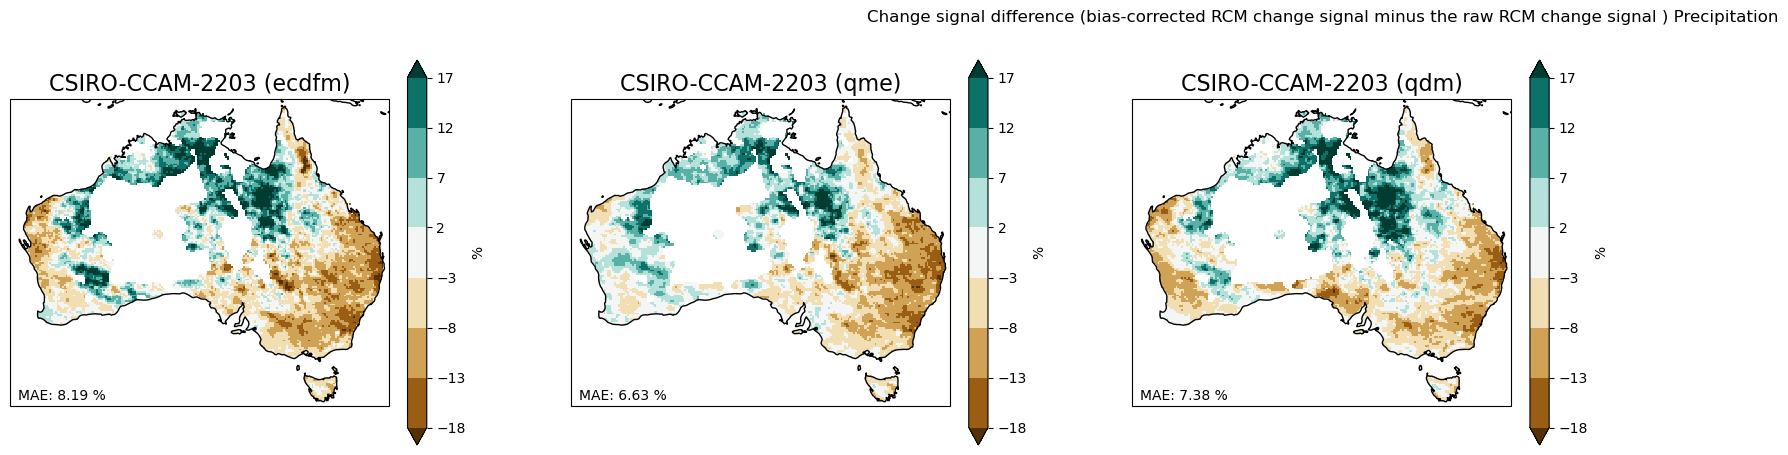

In [21]:
plot_comparison(variable, 'CSIRO-ACCESS-ESM1-5', 'CSIRO-CCAM-2203', 'xvalidation', cmap, levels)

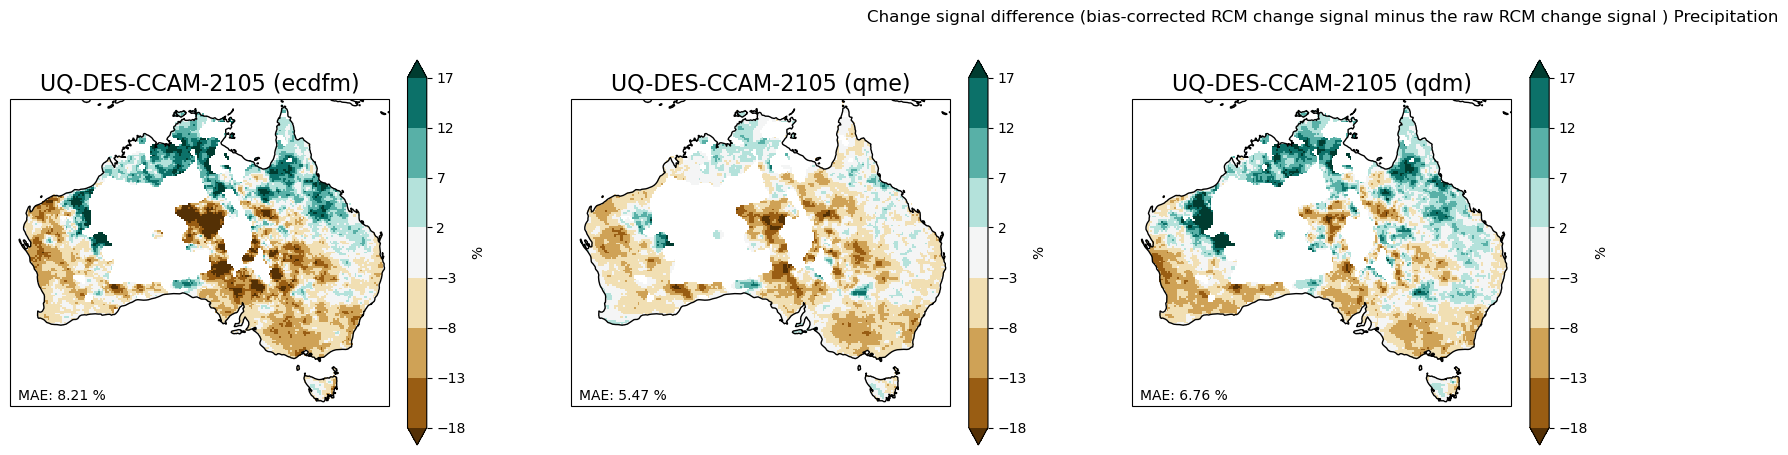

In [22]:
plot_comparison(variable, 'CSIRO-ACCESS-ESM1-5', 'UQ-DES-CCAM-2105', 'xvalidation', cmap, levels)